**"Customer Retention Enhancement through Predictive Analytics"**

In [1]:
import pandas as pd

In [2]:
df = pd.read_excel('/content/Customer_Churn_Data_Large.xlsx')



In [3]:
# Load all sheets into separate DataFrames
excel_file = '/content/Customer_Churn_Data_Large.xlsx'

df_tran = pd.read_excel(excel_file, sheet_name='Transaction_History')
df_service = pd.read_excel(excel_file, sheet_name='Customer_Service')
df_online = pd.read_excel(excel_file, sheet_name='Online_Activity')
df_churn = pd.read_excel(excel_file, sheet_name='Churn_Status')

In [4]:
# Merge step by step on 'CustomerID'
df_merged = df_tran.merge(df_service, on='CustomerID', how='inner') \
                    .merge(df_online, on='CustomerID', how='inner') \
                    .merge(df_churn, on='CustomerID', how='inner')

In [5]:
# Transaction History
agg_tran = df_tran.groupby('CustomerID').agg({
    'AmountSpent': 'sum',
    'TransactionID': 'nunique',
    'ProductCategory': pd.Series.nunique
}).rename(columns={
    'AmountSpent': 'TotalAmountSpent',
    'TransactionID': 'NumTransactions',
    'ProductCategory': 'ProductCategoryDiversity'
}).reset_index()

# Customer Service
agg_service = df_service.groupby('CustomerID').agg({
    'InteractionID': 'nunique',
    'ResolutionStatus': lambda x: (x != 'Resolved').sum(),
    'InteractionType': pd.Series.nunique
}).rename(columns={
    'InteractionID': 'NumInteractions',
    'ResolutionStatus': 'UnresolvedInteractions',
    'InteractionType': 'InteractionTypeDiversity'
}).reset_index()

# Online Activity
df_online['LastLoginDate'] = pd.to_datetime(df_online['LastLoginDate'])
agg_online = df_online.groupby('CustomerID').agg({
    'LoginFrequency': 'mean',
    'LastLoginDate': 'max',
    'ServiceUsage': pd.Series.mode
}).rename(columns={
    'LoginFrequency': 'AvgLoginFrequency',
    'ServiceUsage': 'PreferredPlatform'
}).reset_index()

# Churn Status (already one row per customer)
agg_churn = df_churn.drop_duplicates(subset='CustomerID')

In [6]:
df_merged = agg_tran.merge(agg_service, on='CustomerID', how='left') \
                    .merge(agg_online, on='CustomerID', how='left') \
                    .merge(agg_churn[['CustomerID', 'ChurnStatus']], on='CustomerID', how='left')

In [7]:
# Days since last login
df_merged['DaysSinceLastLogin'] = (pd.to_datetime('today') - df_merged['LastLoginDate']).dt.days
df_merged.drop(columns=['LastLoginDate'], inplace=True)

In [8]:
df_merged.head()
df_merged.info()
df_merged.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CustomerID                1000 non-null   int64  
 1   TotalAmountSpent          1000 non-null   float64
 2   NumTransactions           1000 non-null   int64  
 3   ProductCategoryDiversity  1000 non-null   int64  
 4   NumInteractions           668 non-null    float64
 5   UnresolvedInteractions    668 non-null    float64
 6   InteractionTypeDiversity  668 non-null    float64
 7   AvgLoginFrequency         1000 non-null   float64
 8   PreferredPlatform         1000 non-null   object 
 9   ChurnStatus               1000 non-null   int64  
 10  DaysSinceLastLogin        1000 non-null   int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 86.1+ KB


,0
CustomerID,0
TotalAmountSpent,0
NumTransactions,0
ProductCategoryDiversity,0
NumInteractions,332
UnresolvedInteractions,332
InteractionTypeDiversity,332
AvgLoginFrequency,0
PreferredPlatform,0
ChurnStatus,0


In [9]:
df_merged.head()

,CustomerID,TotalAmountSpent,NumTransactions,ProductCategoryDiversity,NumInteractions,UnresolvedInteractions,InteractionTypeDiversity,AvgLoginFrequency,PreferredPlatform,ChurnStatus,DaysSinceLastLogin
0,1,416.50,1,1,1.0,0.0,1.0,34.0,Mobile App,0,628
1,2,1547.42,7,4,1.0,0.0,1.0,5.0,Website,1,583
2,3,1702.98,6,4,1.0,0.0,1.0,3.0,Website,0,603
3,4,917.29,5,4,2.0,1.0,1.0,2.0,Website,0,685
4,5,2001.49,8,3,NaN,NaN,NaN,41.0,Website,0,622


In [10]:
df_merged[['NumInteractions', 'UnresolvedInteractions', 'InteractionTypeDiversity']] = \
    df_merged[['NumInteractions', 'UnresolvedInteractions', 'InteractionTypeDiversity']].fillna(0)

In [11]:
df_merged.isnull().sum()

,0
CustomerID,0
TotalAmountSpent,0
NumTransactions,0
ProductCategoryDiversity,0
NumInteractions,0
UnresolvedInteractions,0
InteractionTypeDiversity,0
AvgLoginFrequency,0
PreferredPlatform,0
ChurnStatus,0


In [12]:
df_merged = df_merged.drop(columns=['CustomerID'])

In [13]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   TotalAmountSpent          1000 non-null   float64
 1   NumTransactions           1000 non-null   int64  
 2   ProductCategoryDiversity  1000 non-null   int64  
 3   NumInteractions           1000 non-null   float64
 4   UnresolvedInteractions    1000 non-null   float64
 5   InteractionTypeDiversity  1000 non-null   float64
 6   AvgLoginFrequency         1000 non-null   float64
 7   PreferredPlatform         1000 non-null   object 
 8   ChurnStatus               1000 non-null   int64  
 9   DaysSinceLastLogin        1000 non-null   int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 78.3+ KB


In [14]:
df_merged ['DaysSinceLastLogin'] = pd.to_datetime(df_merged['DaysSinceLastLogin'])

In [15]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   TotalAmountSpent          1000 non-null   float64       
 1   NumTransactions           1000 non-null   int64         
 2   ProductCategoryDiversity  1000 non-null   int64         
 3   NumInteractions           1000 non-null   float64       
 4   UnresolvedInteractions    1000 non-null   float64       
 5   InteractionTypeDiversity  1000 non-null   float64       
 6   AvgLoginFrequency         1000 non-null   float64       
 7   PreferredPlatform         1000 non-null   object        
 8   ChurnStatus               1000 non-null   int64         
 9   DaysSinceLastLogin        1000 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(3), object(1)
memory usage: 78.3+ KB


In [16]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()

In [17]:
df_merged ['yearD'] = df_merged['DaysSinceLastLogin'].dt.year
df_merged ['monthD'] = df_merged['DaysSinceLastLogin'].dt.month
df_merged ['dayD'] = df_merged['DaysSinceLastLogin'].dt.day

df_merged = df_merged.drop(columns=['DaysSinceLastLogin'])

In [18]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   TotalAmountSpent          1000 non-null   float64
 1   NumTransactions           1000 non-null   int64  
 2   ProductCategoryDiversity  1000 non-null   int64  
 3   NumInteractions           1000 non-null   float64
 4   UnresolvedInteractions    1000 non-null   float64
 5   InteractionTypeDiversity  1000 non-null   float64
 6   AvgLoginFrequency         1000 non-null   float64
 7   PreferredPlatform         1000 non-null   object 
 8   ChurnStatus               1000 non-null   int64  
 9   yearD                     1000 non-null   int32  
 10  monthD                    1000 non-null   int32  
 11  dayD                      1000 non-null   int32  
dtypes: float64(5), int32(3), int64(3), object(1)
memory usage: 82.2+ KB


In [19]:
df_merged.select_dtypes(include=['number']).columns

Index(['TotalAmountSpent', 'NumTransactions', 'ProductCategoryDiversity',
       'NumInteractions', 'UnresolvedInteractions', 'InteractionTypeDiversity',
       'AvgLoginFrequency', 'ChurnStatus', 'yearD', 'monthD', 'dayD'],
      dtype='object')

In [20]:
number_column = ['TotalAmountSpent', 'NumTransactions', 'ProductCategoryDiversity',
       'NumInteractions', 'UnresolvedInteractions', 'InteractionTypeDiversity',
       'AvgLoginFrequency', 'yearD', 'monthD', 'dayD']

In [21]:
for i in number_column:
  minmax.fit(df_merged[[i]])
  df_merged[i] = minmax.transform(df_merged[[i]])

In [22]:
df_merged

,TotalAmountSpent,NumTransactions,ProductCategoryDiversity,NumInteractions,UnresolvedInteractions,InteractionTypeDiversity,AvgLoginFrequency,PreferredPlatform,ChurnStatus,yearD,monthD,dayD
0,0.120459,0.000,0.00,0.5,0.0,0.5,0.687500,Mobile App,0,0.0,0.0,0.0
1,0.455424,0.750,0.75,0.5,0.0,0.5,0.083333,Website,1,0.0,0.0,0.0
2,0.501499,0.625,0.75,0.5,0.0,0.5,0.041667,Website,0,0.0,0.0,0.0
3,0.268787,0.500,0.75,1.0,0.5,0.5,0.020833,Website,0,0.0,0.0,0.0
4,0.589914,0.875,0.50,0.0,0.0,0.0,0.833333,Website,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.064406,0.000,0.00,0.0,0.0,0.0,0.770833,Mobile App,0,0.0,0.0,0.0
996,0.121443,0.125,0.25,0.0,0.0,0.0,0.083333,Mobile App,0,0.0,0.0,0.0
997,0.071781,0.000,0.00,0.0,0.0,0.0,0.958333,Website,0,0.0,0.0,0.0
998,0.705951,1.000,0.75,0.0,0.0,0.0,0.458333,Website,0,0.0,0.0,0.0


In [23]:
df_merged.select_dtypes(include=['object']).columns

Index(['PreferredPlatform'], dtype='object')

In [24]:
df_mergedP = pd.get_dummies(df_merged['PreferredPlatform']).astype(int)
df_merged = pd.concat([df_merged, df_mergedP], axis=1)
df_merged = df_merged.drop(columns=['PreferredPlatform'])

In [25]:
df_merged.head()

,TotalAmountSpent,NumTransactions,ProductCategoryDiversity,NumInteractions,UnresolvedInteractions,InteractionTypeDiversity,AvgLoginFrequency,ChurnStatus,yearD,monthD,dayD,Mobile App,Online Banking,Website
0,0.120459,0.000,0.00,0.5,0.0,0.5,0.687500,0,0.0,0.0,0.0,1,0,0
1,0.455424,0.750,0.75,0.5,0.0,0.5,0.083333,1,0.0,0.0,0.0,0,0,1
2,0.501499,0.625,0.75,0.5,0.0,0.5,0.041667,0,0.0,0.0,0.0,0,0,1
3,0.268787,0.500,0.75,1.0,0.5,0.5,0.020833,0,0.0,0.0,0.0,0,0,1
4,0.589914,0.875,0.50,0.0,0.0,0.0,0.833333,0,0.0,0.0,0.0,0,0,1


In [26]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   TotalAmountSpent          1000 non-null   float64
 1   NumTransactions           1000 non-null   float64
 2   ProductCategoryDiversity  1000 non-null   float64
 3   NumInteractions           1000 non-null   float64
 4   UnresolvedInteractions    1000 non-null   float64
 5   InteractionTypeDiversity  1000 non-null   float64
 6   AvgLoginFrequency         1000 non-null   float64
 7   ChurnStatus               1000 non-null   int64  
 8   yearD                     1000 non-null   float64
 9   monthD                    1000 non-null   float64
 10  dayD                      1000 non-null   float64
 11  Mobile App                1000 non-null   int64  
 12  Online Banking            1000 non-null   int64  
 13  Website                   1000 non-null   int64  
dtypes: float6

In [27]:
df_merged.columns

Index(['TotalAmountSpent', 'NumTransactions', 'ProductCategoryDiversity',
       'NumInteractions', 'UnresolvedInteractions', 'InteractionTypeDiversity',
       'AvgLoginFrequency', 'ChurnStatus', 'yearD', 'monthD', 'dayD',
       'Mobile App', 'Online Banking', 'Website'],
      dtype='object')

In [28]:
x = df_merged[['TotalAmountSpent', 'NumTransactions', 'ProductCategoryDiversity',
       'NumInteractions', 'UnresolvedInteractions', 'InteractionTypeDiversity',
       'AvgLoginFrequency', 'yearD', 'monthD', 'dayD','Mobile App', 'Online Banking', 'Website']]

In [29]:
y = df_merged['ChurnStatus']

In [30]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   TotalAmountSpent          1000 non-null   float64
 1   NumTransactions           1000 non-null   float64
 2   ProductCategoryDiversity  1000 non-null   float64
 3   NumInteractions           1000 non-null   float64
 4   UnresolvedInteractions    1000 non-null   float64
 5   InteractionTypeDiversity  1000 non-null   float64
 6   AvgLoginFrequency         1000 non-null   float64
 7   ChurnStatus               1000 non-null   int64  
 8   yearD                     1000 non-null   float64
 9   monthD                    1000 non-null   float64
 10  dayD                      1000 non-null   float64
 11  Mobile App                1000 non-null   int64  
 12  Online Banking            1000 non-null   int64  
 13  Website                   1000 non-null   int64  
dtypes: float6

In [31]:
df_merged.isnull().sum()

,0
TotalAmountSpent,0
NumTransactions,0
ProductCategoryDiversity,0
NumInteractions,0
UnresolvedInteractions,0
InteractionTypeDiversity,0
AvgLoginFrequency,0
ChurnStatus,0
yearD,0
monthD,0


In [32]:
y.value_counts()

,count
ChurnStatus,
0,796
1,204


In [33]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
x,y = smote.fit_resample(x,y)

In [35]:
y.value_counts()

,count
ChurnStatus,
0,796
1,796


In [37]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y, train_size=0.80, random_state=42)

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import ExtraTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report


In [39]:
algorithms = [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), KNeighborsClassifier(), SVC(), ExtraTreeClassifier(), GaussianNB()]

In [40]:
for i in algorithms:
  model = i.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  print(i)
  print(classification_report(y_test, y_pred))

LogisticRegression()
              precision    recall  f1-score   support

           0       0.53      0.51      0.52       157
           1       0.54      0.57      0.56       162

    accuracy                           0.54       319
   macro avg       0.54      0.54      0.54       319
weighted avg       0.54      0.54      0.54       319

DecisionTreeClassifier()
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       157
           1       0.81      0.73      0.77       162

    accuracy                           0.78       319
   macro avg       0.78      0.78      0.78       319
weighted avg       0.78      0.78      0.78       319

RandomForestClassifier()
              precision    recall  f1-score   support

           0       0.80      0.85      0.83       157
           1       0.85      0.80      0.82       162

    accuracy                           0.82       319
   macro avg       0.83      0.82      0.82       319
wei

RandomForestClassifier is the best model 82%

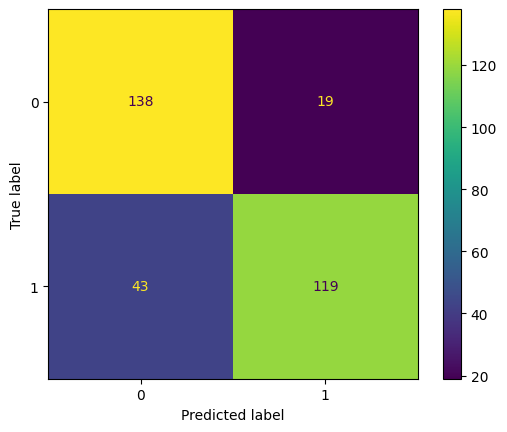

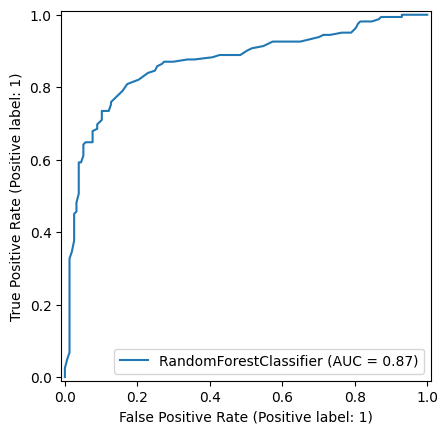

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay

model = RandomForestClassifier().fit(x_train, y_train)
y_pred = model.predict(x_test)

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(model, x_test, y_test)

# ROC Curve
RocCurveDisplay.from_estimator(model, x_test, y_test)

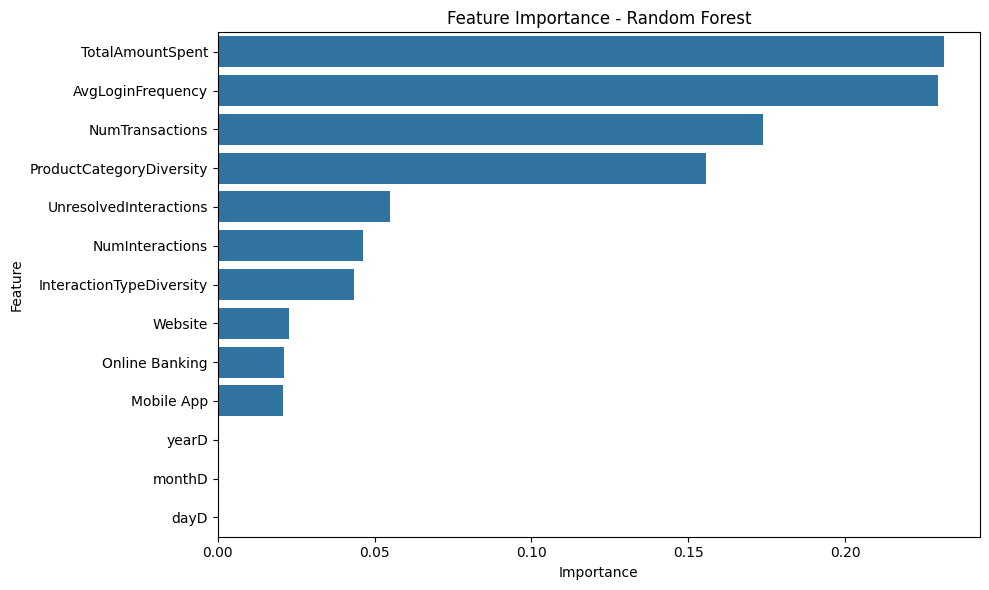

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = model.feature_importances_
features = x.columns

feat_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_df)
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.show()